In [1]:
from collections import defaultdict
from typing import Dict
from pathlib import Path
from IPython.display import display
import pandas as pd
import numpy as np
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice
from pymatgen.util.coord import *
from pymatgen.core.periodic_table import Element, ElementBase, DummySpecie
from copy import deepcopy
import matplotlib.patches as mpatches

from ase.visualize.plot import plot_atoms
from pymatgen.io.ase import AseAtomsAdaptor
%matplotlib inline
%config InlineBackend.figure_format='retina'

/home/al-maeeni/.conda/envs/exp1/lib/python3.8/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/al-maeeni/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [2]:
from pymatgen.optimization.neighbors import find_points_in_spheres
from pymatgen.analysis.local_env import CrystalNN, MinimumDistanceNN
from copy import deepcopy

In [3]:
data = pd.read_pickle(
    '../datasets/processed/high_density_defects/WSe2_500/data.pickle.gz'
    # '../datasets/processed/high_density_defects/GaSe_500/data.pickle.gz'
    # '../datasets/processed/high_density_defects/hBN_spin_500/data.pickle.gz',
    # '../datasets/processed/high_density_defects/BP_spin_500/data.pickle.gz'
    )

In [8]:
plotter = lambda s: view(AseAtomsAdaptor().get_atoms(s), viewer='ngl')

In [6]:
struct = data.iloc[77].initial_structure


In [3]:
def get_pristine_lattice(struct, defect_rep):
    """ Get a lattice without defects 
    """
    struct = deepcopy(struct)
    replace_dict = {}
    for atom in defect_rep:
        was = ElementBase.from_Z(atom.properties['was'])
        # The element type in sparse representaion is compound thus we need to make it an element
        current = atom.species.elements[0]
        if current == DummySpecie():
            struct.append(was, atom.coords, coords_are_cartesian=True)
        else:
            replace_dict[current] = was
    # inplace operation hence the deepcopy above
    struct.replace_species(replace_dict)
    struct.lattice._pbc = (1, 1, 1)

    return struct

def plt_plotter(struct, ax=None, rotation=('0x,0y,0z'), **kwargs):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 10))
    plot_atoms(AseAtomsAdaptor.get_atoms(struct), ax, radii=0.3, rotation=rotation, **kwargs)
    return ax

In [9]:
supercell = unitcell.copy()
for idx, site in enumerate(supercell):
    site.properties['idx'] = idx
    
supercell.make_supercell([2, 2, 1])


In [11]:
struct = get_pristine_lattice(data.iloc[77].initial_structure, data.iloc[77].defect_representation)

NameError: name 'data' is not defined

In [193]:
from pymatgen.io import cif
unitcell = cif.CifParser('../defects_generation/molecules/P.cif').get_structures(primitive=False)[0]

In [194]:
plotter(unitcell)

In [15]:
import cProfile
data = pd.read_pickle(
    '../datasets/processed/high_density_defects/WSe2_500/data.pickle.gz'
    # '../datasets/processed/high_density_defects/GaSe_500/data.pickle.gz'
    # '../datasets/processed/high_density_defects/hBN_spin_500/data.pickle.gz',
    # '../datasets/processed/high_density_defects/BP_spin_500/data.pickle.gz'
)
from pymatgen.io import cif
unitcell = cif.CifParser('../defects_generation/molecules/hBN_spin_500.cif').get_structures(primitive=False)[0]

FileNotFoundError: [Errno 2] No such file or directory: '../defects_generation/molecules/hBN_spin_500.cif'

In [13]:
from functools import cached_property
from pymatgen.analysis.local_env import CrystalNN
from functools import lru_cache
from operator import itemgetter
from pymatgen.core.sites import PeriodicSite, Site

class Shells:
    def __init__(self, structure):
        self.structure = structure
        self.nn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False)
  
    @cached_property
    def _all_nn_info(self):
        return self.nn.get_all_nn_info(self.structure)

    def get_nn_shell_info(self, site_idx, shell_idx):
        sites = self.nn._get_nn_shell_info(self.structure, self._all_nn_info, site_idx, shell_idx)
        output = []
        for info in sites:
            orig_site = self.structure[info["site_index"]]
            info["site"] = PeriodicSite(
                orig_site.species,
                np.add(orig_site.frac_coords, info["image"]),
                self.structure.lattice,
                properties=orig_site.properties,
            )
            output.append(info['site'])
        return output


class EOS:
    def __init__(self, num_shells=7) -> None:
        self.num_shells = num_shells

    @staticmethod
    def remove_other_species(structure, center):
        _struct = structure.copy()
        # _struct.remove_species(set(_struct.species).difference({center.spiece}))
        if (num_unique_species := len(set(structure.species))) == 1:
            return Structure.from_sites([site for site in structure if site.properties['center_index'] is not None] + [center])
        elif num_unique_species == 2:
            sites = [site for site in structure if site.specie != center.specie]
            sites.append(center)
            return Structure.from_sites(sites)
        else:
            raise NotImplementedError

    @staticmethod
    def get_distance_of_atoms_on_z_plane(center, sites):
        # return sorted({np.linalg.norm(site.coords - center.coords).round(3) for site in sites if site.coords[2].round(3) == center.coords[2].round(3)})
        return sorted({d for site in sites if (d := np.linalg.norm(site.coords[..., :2] - center.coords[..., :2]).round(3)) != 0})
        
    def get_shell(self, structure, site_idx, num_shells):
        shells = []
        # for i in range(1, num_shells):
        # shells.append(
        return self.shells_obj.get_nn_shell_info(site_idx, num_shells)
        # return shells

    def add_site_index_to_structure(self, structure):
        for i, site in enumerate(structure):
            site.properties['site_index'] = i
        return structure

    def find_center_index(self, structure, index):
        for i, site in enumerate(structure):
            if site.properties.get('center_index', -1) == index:
                return i
        
    def get_augmented_struct(self, structure):
        for center_idx, site in enumerate(structure):
            # add center index
            structure[center_idx].properties['center_index'] = center_idx 
            # get shells finder object
            self.shells_obj = Shells(structure)
            # get the shells
            shells_sites = self.get_shell(structure, self.find_center_index(structure, center_idx), self.num_shells)
            # remove all other species
            _struct = self.remove_other_species(Structure.from_sites(shells_sites), site)
            # add shells to the site
            site.properties['shells'] = self.get_distance_of_atoms_on_z_plane(site, [site for site in _struct])
            # delete the center index
            del site.properties['center_index']

        assert all(map(lambda s: 'shells' in s.properties, structure))
        return structure

eos = EOS(12)
augmented_struct = eos.get_augmented_struct(unitcell)
# cProfile.run('eos.get_eos_features(supercell)')


/home/al-maeeni/.conda/envs/exp1/lib/python3.8/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property center_index. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")
/home/al-maeeni/.conda/envs/exp1/lib/python3.8/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property shells. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


In [14]:
tmp = augmented_struct.copy()
tmp.make_supercell([8, 8, 1])

tmp

In [11]:
tmp

Structure Summary
Lattice
    abc : 26.399344 36.807408 20.0
 angles : 90.0 90.0 90.0
 volume : 19433.82851080704
      A : 26.399344 0.0 1.6164936064594941e-15
      B : 5.9190826480689035e-15 36.807408 2.2538037196055342e-15
      C : 0.0 0.0 20.0
PeriodicSite: P (0.0000, 2.7079, 4.1825) [0.0000, 0.0736, 0.2091]
PeriodicSite: P (0.0000, 7.3088, 4.1825) [0.0000, 0.1986, 0.2091]
PeriodicSite: P (0.0000, 11.9098, 4.1825) [0.0000, 0.3236, 0.2091]
PeriodicSite: P (0.0000, 16.5107, 4.1825) [0.0000, 0.4486, 0.2091]
PeriodicSite: P (0.0000, 21.1116, 4.1825) [0.0000, 0.5736, 0.2091]
PeriodicSite: P (0.0000, 25.7125, 4.1825) [0.0000, 0.6986, 0.2091]
PeriodicSite: P (0.0000, 30.3135, 4.1825) [0.0000, 0.8236, 0.2091]
PeriodicSite: P (0.0000, 34.9144, 4.1825) [0.0000, 0.9486, 0.2091]
PeriodicSite: P (3.2999, 2.7079, 4.1825) [0.1250, 0.0736, 0.2091]
PeriodicSite: P (3.2999, 7.3088, 4.1825) [0.1250, 0.1986, 0.2091]
PeriodicSite: P (3.2999, 11.9098, 4.1825) [0.1250, 0.3236, 0.2091]
PeriodicSite: P (

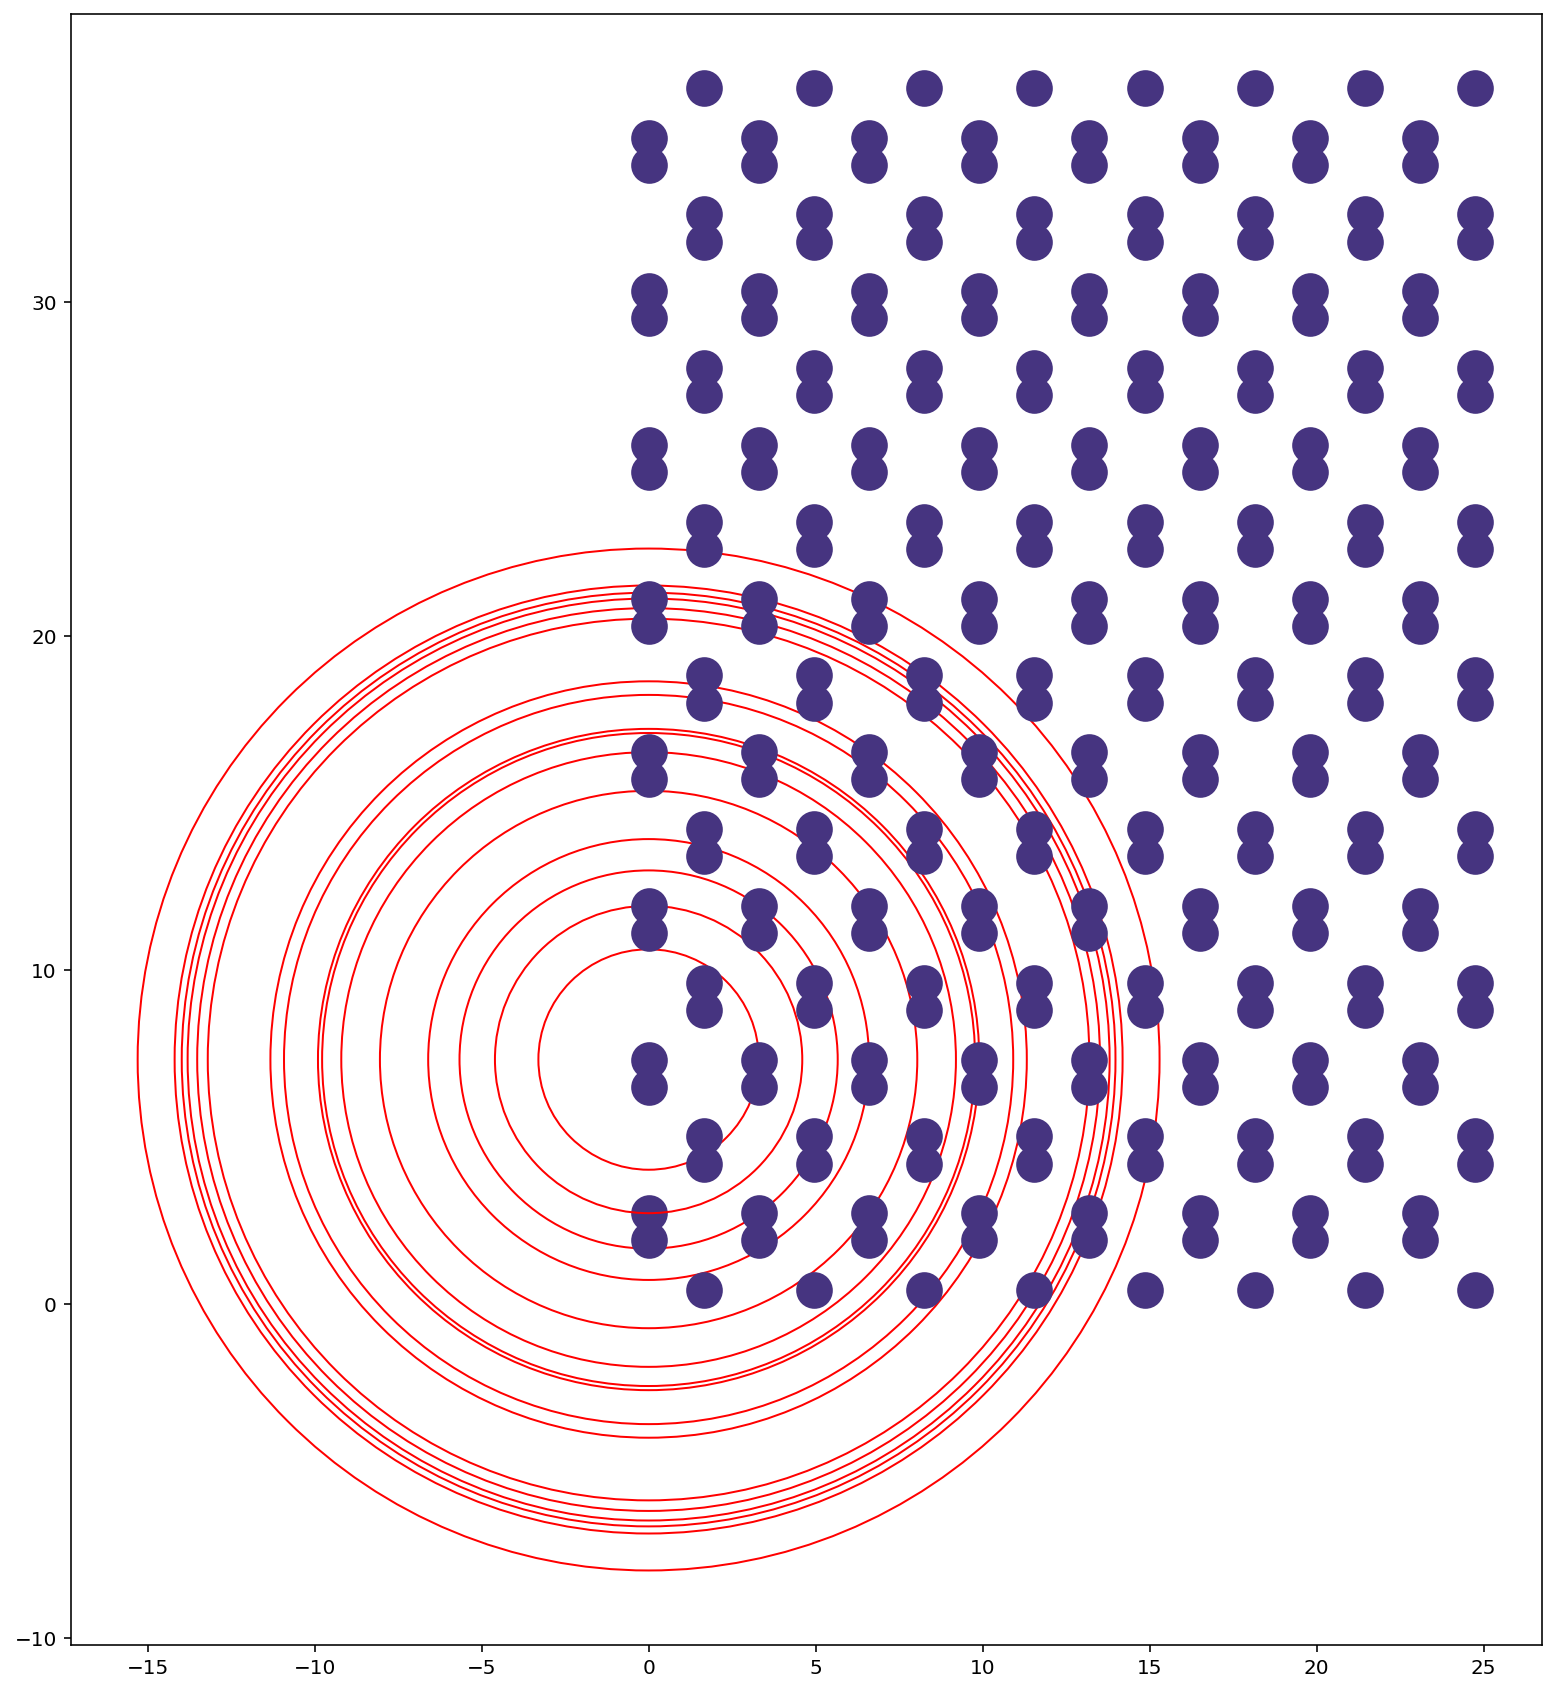

In [10]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

_type = 'P'
centers = [site for site in tmp if site.specie.symbol == _type]
center = centers[1]

fig, axs = plt.subplots(1, 1, figsize=(15, 15))
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=100)

for site in tmp:
    axs.scatter(site.coords[0], site.coords[1], color=cmap(norm(site.specie.number)), s=site.specie.number*20)
    if all(site.coords[..., :2].round(3) == center.coords[..., :2].round(3)):
        for i, r in enumerate(site.properties['shells']):
            # draw circle around center
            circle = plt.Circle((center.coords[0], center.coords[1]), r, color='r', fill=False, )
            axs.add_patch(circle)
            if i == 15: break

axs.set_aspect('equal')   
axs.autoscale_view() 


NameError: name 'shells' is not defined

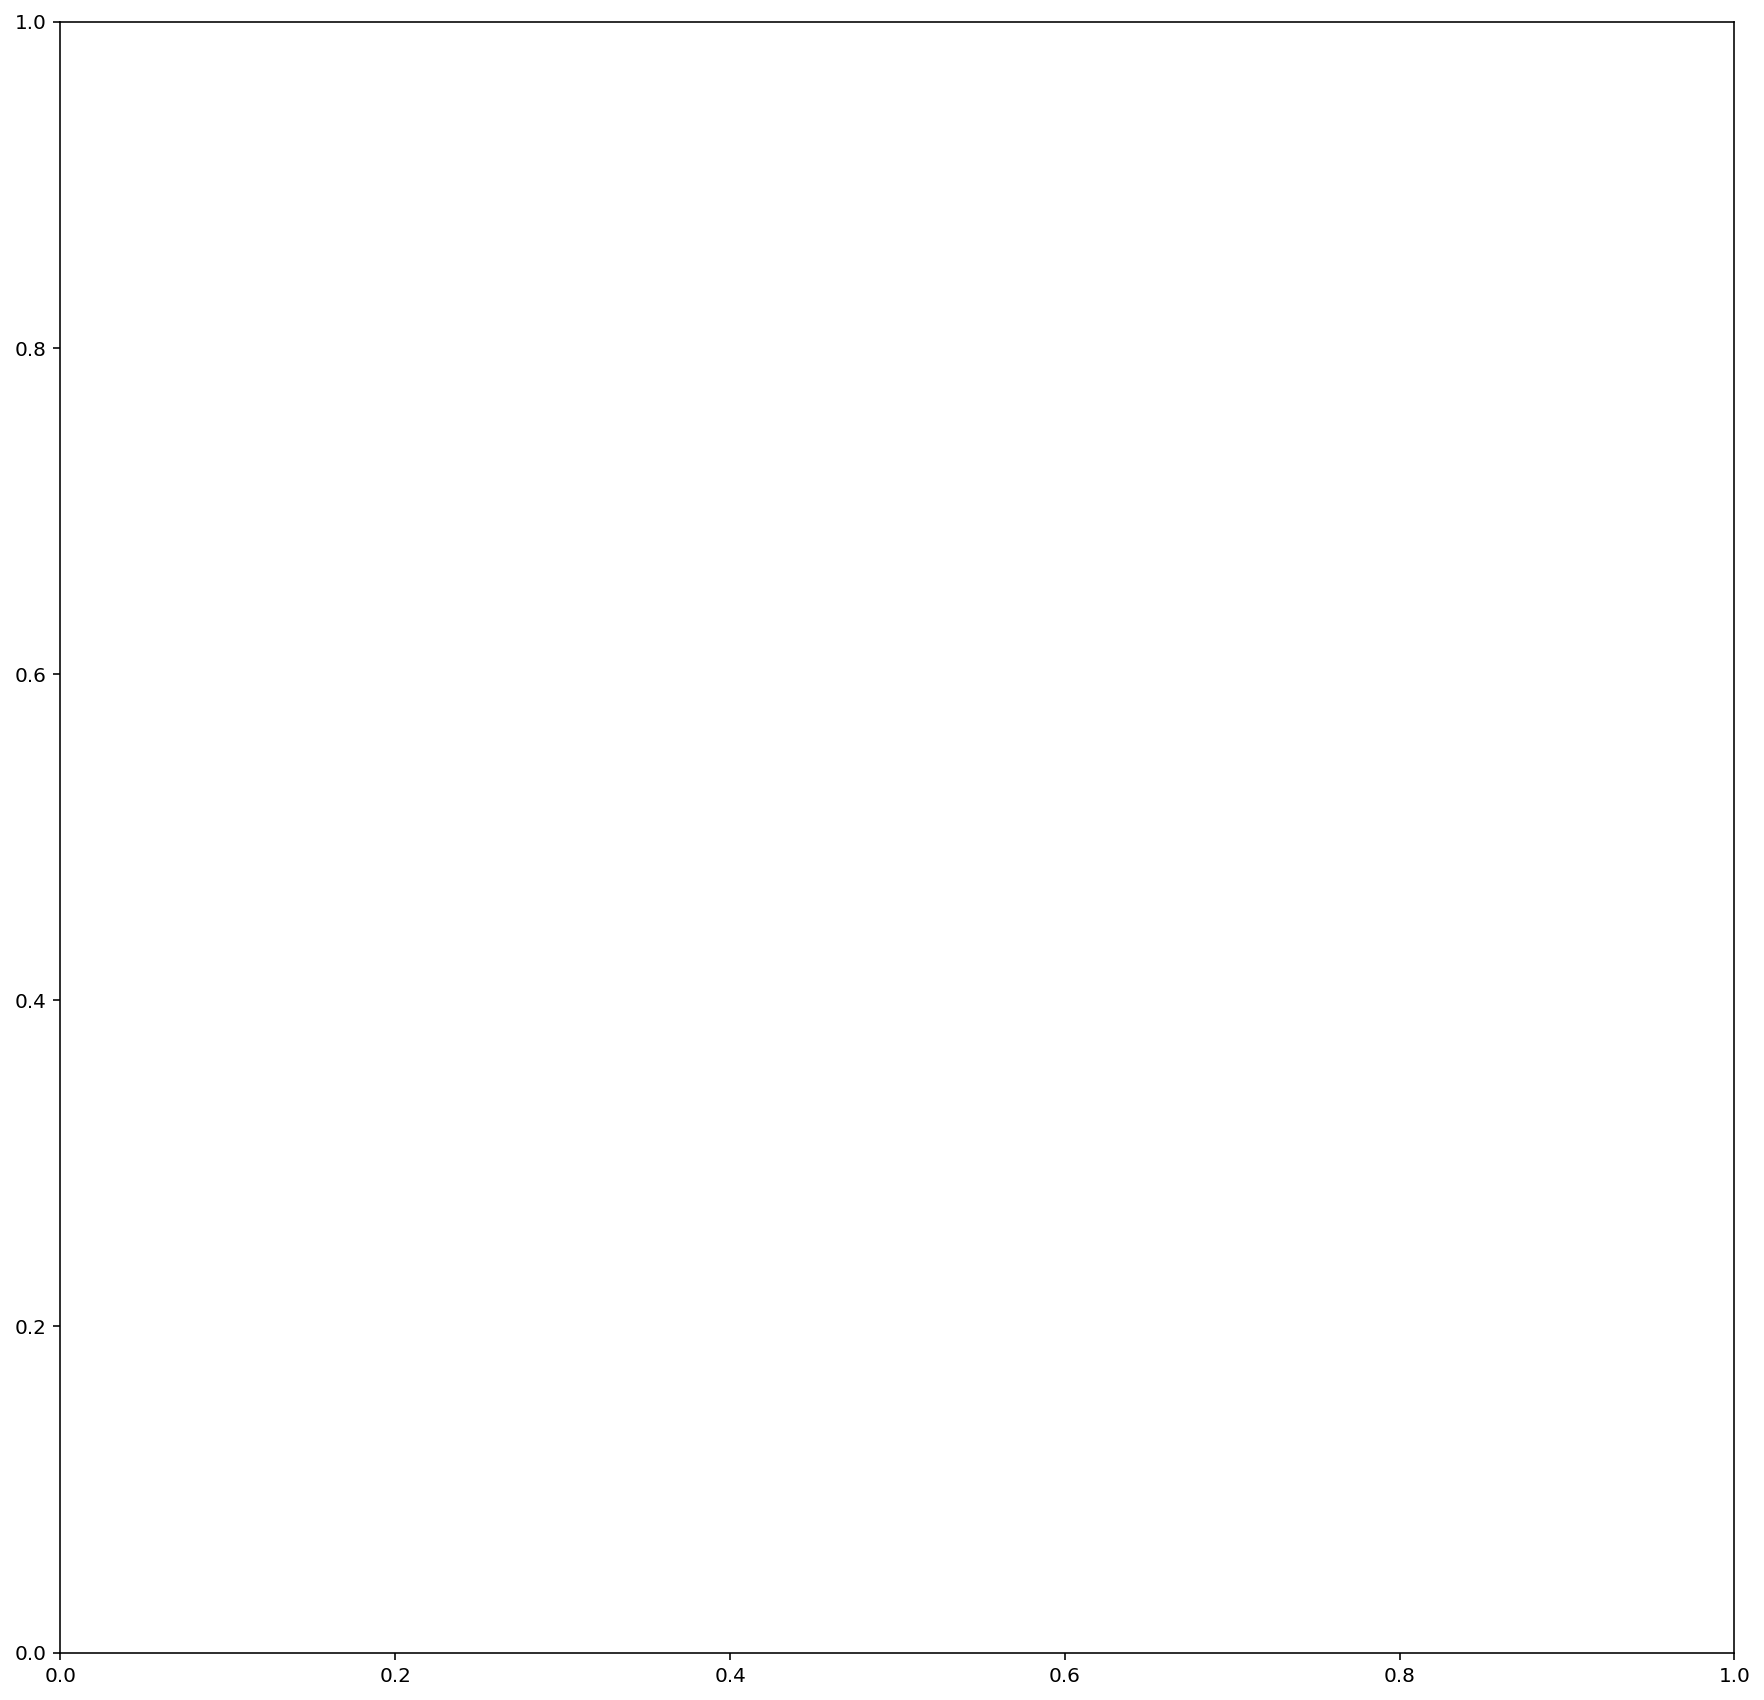

In [20]:
_type = 'Mo'
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
for point in shells[_type][-1]:
    axs.scatter(point.coords[0], point.coords[1],  c='b', s=100)
    if point.coords[2].round(3) == centers[_type].coords[2].round(3):
        r = np.linalg.norm(centers[_type].coords - point.coords)
        # draw circle around center
        circle = plt.Circle((centers[_type].coords[0], centers[_type].coords[1]), r, color='r', fill=False)
        axs.add_artist(circle)


axs.scatter(centers[_type].coords[0], centers[_type].coords[1], s=100, c='r')
    

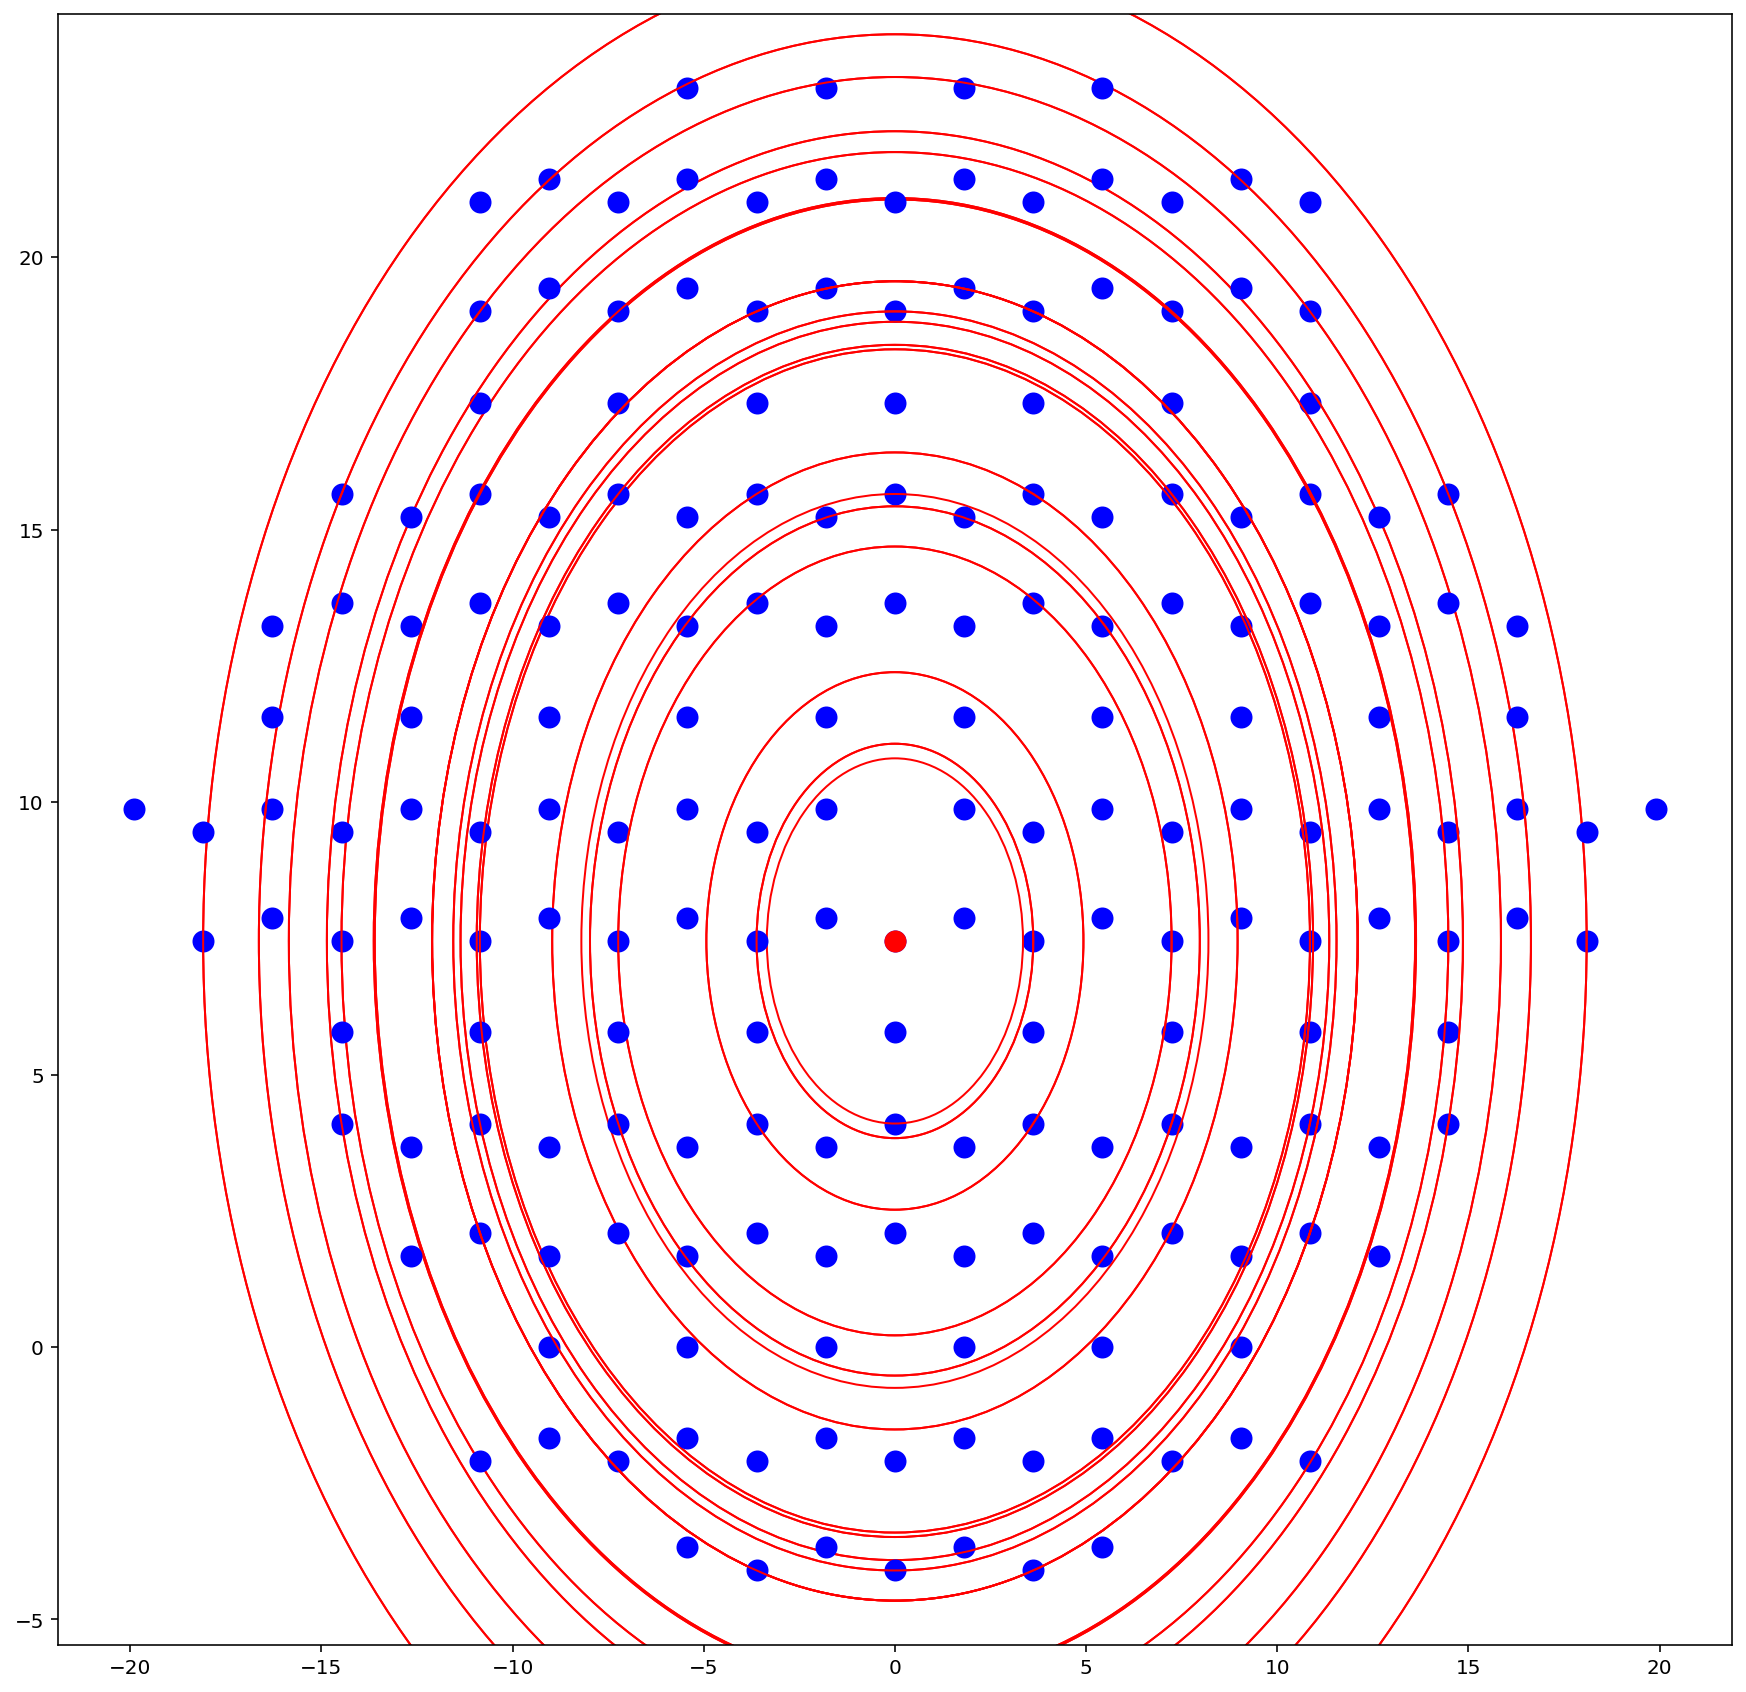

In [114]:
_type = 'O'
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
for point in shells[_type][-1]:
    axs.scatter(point.coords[0], point.coords[1],  c='b', s=100)
    if point.coords[2].round(3) == centers[_type].coords[2].round(3):
        r = np.linalg.norm(centers[_type].coords - point.coords)
        # draw circle around center
        circle = plt.Circle((centers[_type].coords[0], centers[_type].coords[1]), r, color='r', fill=False)
        axs.add_artist(circle)


axs.scatter(centers[_type].coords[0], centers[_type].coords[1], s=100, c='r')
    